In [1]:
%store -r X_final

In [2]:
%store -r y_classification

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import model_selection, linear_model, metrics, preprocessing, pipeline, svm, neighbors

In [4]:
# preimenujmo X_final u X, a y_classification koji je tip Series prebacimo u niz, zato sto je i X visedimenzioni niz, 
# pa da budu istog tipa
# to nam je sad skup podataka za modele klasifikacije
X = X_final
y = y_classification.to_numpy()

In [5]:
np.random.seed(7)

# Podela skupa podataka 

In [6]:
# stratifikujemo po y da bismo imali u oba skupa jednak odnos instanci obe klase
X_train_and_validation, X_test, y_train_and_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

In [7]:
print('U skupu za treniranje i validaciju imamo ', X_train_and_validation.shape[0], 'instanci.')
print('U skupu za testiranje imamo ', X_test.shape[0], 'instanci.')

U skupu za treniranje i validaciju imamo  4422 instanci.
U skupu za testiranje imamo  1106 instanci.


# Logisticka regresija

In [8]:
# ovde nemamo hiperparametre, pa model treniramo na skupu za trening i validaciju, a evaluiramo na skupu za testiranje

In [9]:
# prvo treba da skaliramo numericke atribute, koji se nalaze u prve 4 kolone u X

In [10]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_and_validation[:, 0:4])
X_train_and_validation[:, 0:4] = scaler.transform(X_train_and_validation[:, 0:4])
X_test[:, 0:4] = scaler.transform(X_test[:, 0:4])

In [11]:
# model
logistic_regression = linear_model.LogisticRegression(max_iter=1000)

In [12]:
# treniranje modela 
# nije iskonvergiralo ni bez max_iter, ni sa 500, pa je stavljeno 1000
logistic_regression.fit(X_train_and_validation, y_train_and_validation)

LogisticRegression(max_iter=1000)

In [13]:
# ciljna funkcija logisticke regresije je zadata sigmoidnom funkcijom
# ako je vrednost ciljne funkcije veca od praga (podrazumevan prag je 0.5), predvidja se pozitivna klasa, a ako je manja od
# praga, predvidja se negativna klasa

In [14]:
# prag moze biti izmedju 0 i 1
# variranjem praga mozemo da kontrolisemo relativne performanse u tacnosti, senzitivnosti i specificnosti
# zato cemo varirati prag

In [15]:
# za metriku cemo racunati tacnost, senzitivnost (udeo pravih pozitivnih instanci) i specificnost (udeo pravih negativnih 
# instanci)
# accuracy = (TP+TN)/(TP+TN+FP+FN)
# sensitivity = TP/(TP+FN)
# specificity = TN/(TN+FP) 

In [16]:
# razlicite vrednosti praga
# ako je vrednost ciljne funkcije manja od praga, predvidja se negativna klasa
# ako je veca, predvidja se pozitivna klasa
pragovi = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

In [17]:
#  funkcije predict_proba daje ocene verovatnoća pripadnosti pozitivnoj tj. negativnoj klasi, za svaku instancu posebno
logistic_regression.predict_proba(X_test)

array([[0.43379349, 0.56620651],
       [0.87358722, 0.12641278],
       [0.11250804, 0.88749196],
       ...,
       [0.83831127, 0.16168873],
       [0.50217096, 0.49782904],
       [0.63498973, 0.36501027]])

In [18]:
logistic_regression.classes_

array([0, 1])

In [19]:
# vidimo da je levo negativna klasa, a desno pozitivna
# zato nam je izlaz funkcije predict_proba matrica cija je prva kolona verovatnoca da instance pripadaju negativnoj klasi,
# a druga kolona verovatnoca da pripadaju pozitivnoj klasi

In [20]:
# sada cemo za razlicite vrednosti praga racunati gore pomenute metrike
accuracy_scores = []
sensitivity_scores = []
specificity_scores = []

for prag in pragovi:
    # gledamo da li je verovatnoca pripadanja pozitivnoj klasi veca od praga
    # ako jeste, funkcija astype(int) vraca vrednost 1, a ako nije, vraca vrednost 0
    y_predicted = (logistic_regression.predict_proba(X_test)[:,1] > prag).astype(int)
    
    # sada nam trebaju vrednosti TN, FP, FN, TP
    # njih nalazimo u matrici konfuzije (samo cemo je poravnati u vektor)
    TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_predicted).ravel()

    accuracy = (TP+TN)/(TP+TN+FP+FN)
    accuracy_scores.append(accuracy)
    sensitivity = TP/(TP+FN)
    sensitivity_scores.append(sensitivity)
    specificity = TN/(TN+FP)
    specificity_scores.append(specificity)

In [21]:
sensitivity_scores = np.array(sensitivity_scores)
specificity_scores = np.array(specificity_scores)

In [22]:
# matrica konfuzije na skupu za test
metrics.confusion_matrix(y_test, logistic_regression.predict(X_test))

array([[508, 117],
       [124, 357]], dtype=int64)

In [23]:
logistic_regression_f1 = metrics.f1_score(y_test, logistic_regression.predict(X_test))
print('f1 score za obican model logisticke regresije: %.3f' %logistic_regression_f1) 

f1 score za obican model logisticke regresije: 0.748


In [24]:
logistic_regression_auc = metrics.auc(1 - specificity_scores, sensitivity_scores)

In [25]:
print('AUC za obican model logisticke regresije: %.3f' %logistic_regression_auc) 

AUC za obican model logisticke regresije: 0.857


In [26]:
# tacnost, senzitivnost i specificnost racunamo za prag 0.5 koji je po defaultu

In [27]:
logistic_regression_accuracy = accuracy_scores[5]
print('Tacnost za obican model logisticke regresije: %.3f' %logistic_regression_accuracy)  

Tacnost za obican model logisticke regresije: 0.782


In [28]:
logistic_regression_sensitivity = sensitivity_scores[5]
print('Senzitivnost za obican model logisticke regresije: %.3f' %logistic_regression_sensitivity) 

Senzitivnost za obican model logisticke regresije: 0.742


In [29]:
logistic_regression_specificity = specificity_scores[5]
print('Specificnost za obican model logisticke regresije: %.3f' %logistic_regression_specificity) 

Specificnost za obican model logisticke regresije: 0.813


# Funkcija za unakrsnu validaciju 

In [30]:
# kao i u slucaju regresije, i ovde cemo napraviti nasu funkciju za unakrsnu validaciju
# funkcija radi unakrsnu validaciju sa 10 slojeva i racuna tacnost kao gresku 

In [31]:
def cross_validation (model, X_trainval, y_trainval):
    
    accuracy_scores = []
    kf = model_selection.KFold(n_splits=10)
    
    for train_indexes, validation_indexes in kf.split(X_trainval, y_trainval):
        # pravimo skup za trening i za validaciju
        X_train = X_trainval[train_indexes]
        y_train = y_trainval[train_indexes]
        X_validation = X_trainval[validation_indexes]
        y_validation = y_trainval[validation_indexes]
        
        # skaliramo 
        scaler = preprocessing.StandardScaler()
        scaler.fit(X_train[:, 0:4])
        X_train[:, 0:4] = scaler.transform(X_train[:, 0:4])
        X_validation[:, 0:4] = scaler.transform(X_validation[:, 0:4])
        
        # obucavanje modela
        model.fit(X_train, y_train)
        
        # evaluacija na skupu za validaciju
        y_val_predicted = model.predict(X_validation)
        accuracy = metrics.accuracy_score(y_validation, y_val_predicted)
        
        accuracy_scores.append(accuracy)
        return accuracy_scores

# Logisticka regresija sa l2 regularizacijom (ridge)

In [32]:
X_train_and_validation, X_test, y_train_and_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

In [33]:
# imamo regularizacioni parametar alpha
alphas = np.array([0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0])

In [34]:
# kada radimo l2 regulazizaciju, postavljamo argumente penalty='l2' i C=1/alpha

In [35]:
Cs = 1/alphas

In [36]:
# sada unakrsnom validacijom biramo optimalni parametar 
optimal_score = 0
optimal_C = 0
validation_scores = []

for C in Cs:
    model = linear_model.LogisticRegression(penalty='l2', C=C, max_iter=2000)
    scores = cross_validation(model, X_train_and_validation, y_train_and_validation)
    score = sum(scores)/len(scores)
    validation_scores.append(score)
    
    if score > optimal_score:
        optimal_score = score
        optimal_C = C

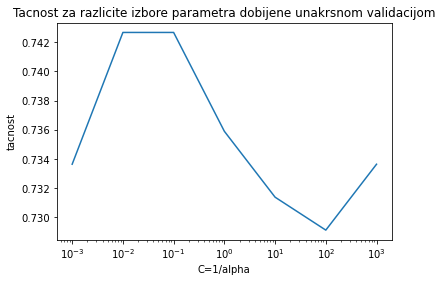

In [37]:
# crtamo grafika tacnosti na validacionom skupu za razlicite vrednosti parametra C=1/alpha
plt.plot(Cs, validation_scores)
plt.title('Tacnost za razlicite izbore parametra dobijene unakrsnom validacijom')
plt.xscale('log')
plt.xlabel('C=1/alpha')
plt.ylabel('tacnost')
plt.show()

In [38]:
print('Optimalna tacnost na skupu za validaciju je: %.3f' %optimal_score)

Optimalna tacnost na skupu za validaciju je: 0.743


In [39]:
print('Optimalo C je: %.1f' %optimal_C)

Optimalo C je: 0.1


In [40]:
# sada sa optimalnim parametrom pravimo konacan model

In [41]:
scaler_l2 = preprocessing.StandardScaler()
scaler_l2.fit(X_train_and_validation[:, 0:4])
X_train_and_validation[:, 0:4] = scaler_l2.transform(X_train_and_validation[:, 0:4])
X_test[:, 0:4] = scaler_l2.transform(X_test[:, 0:4])

In [42]:
# model
logistic_regression_l2 = linear_model.LogisticRegression(penalty='l2', C=optimal_C, max_iter=2000)

In [43]:
logistic_regression_l2.fit(X_train_and_validation, y_train_and_validation)

LogisticRegression(C=0.1, max_iter=2000)

In [44]:
# opet ponavljamo postupak kao kod obicne logisticke regresije - za razlicite pragove racunamo metrike
pragovi

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [45]:
accuracy_scores_l2 = []
sensitivity_scores_l2 = []
specificity_scores_l2 = []

for prag in pragovi:
    # gledamo da li je verovatnoca pripadanja pozitivnoj klasi veca od praga
    # ako jeste, funkcija astype(int) vraca vrednost 1, a ako nije, vraca vrednost 0
    y_predicted = (logistic_regression_l2.predict_proba(X_test)[:,1] > prag).astype(int)
    
    # sada nam trebaju vrednosti TN, FP, FN, TP
    # njih nalazimo u matrici konfuzije (samo cemo je poravnati u vektor)
    TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_predicted).ravel()
    
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    accuracy_scores_l2.append(accuracy)
    sensitivity = TP/(TP+FN)
    sensitivity_scores_l2.append(sensitivity)
    specificity = TN/(TN+FP)
    specificity_scores_l2.append(specificity)

In [46]:
sensitivity_scores_l2 = np.array(sensitivity_scores_l2)
specificity_scores_l2 = np.array(specificity_scores_l2)

In [47]:
# matrica konfuzije na skupu za test
metrics.confusion_matrix(y_test, logistic_regression_l2.predict(X_test))

array([[514, 111],
       [123, 358]], dtype=int64)

In [48]:
l2_f1 = metrics.f1_score(y_test, logistic_regression_l2.predict(X_test))
print('f1 score za model logisticke regresije sa l2 regularizacijom: %.3f' %l2_f1) 

f1 score za model logisticke regresije sa l2 regularizacijom: 0.754


In [49]:
l2_auc = metrics.auc(1 - specificity_scores_l2, sensitivity_scores_l2)

In [50]:
print('AUC za model logisticke regresije sa l2 regularizacijom: %.3f' %l2_auc) 

AUC za model logisticke regresije sa l2 regularizacijom: 0.860


In [51]:
l2_accuracy = accuracy_scores_l2[5]
print('Tacnost za model logisticke regresije sa l2 regularizacijom: %.3f' %l2_accuracy)

Tacnost za model logisticke regresije sa l2 regularizacijom: 0.788


In [52]:
l2_sensitivity = sensitivity_scores_l2[5]
print('Senzitivnost za model logisticke regresije sa l2 regularizacijom: %.3f' %l2_sensitivity)

Senzitivnost za model logisticke regresije sa l2 regularizacijom: 0.744


In [53]:
l2_specificity = specificity_scores_l2[5]
print('Specificnost za model logisticke regresije sa l2 regularizacijom: %.3f' %l2_specificity)

Specificnost za model logisticke regresije sa l2 regularizacijom: 0.822


# Logisticka regresija sa l1 regularizacijom (lasso)

In [54]:
X_train_and_validation, X_test, y_train_and_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

In [55]:
# imamo hiperparametar alpha
alphas

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [56]:
# funkciji prosledjujemo parametar C=1/alpha
Cs = 1/alphas
Cs

array([1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

In [57]:
# sada unakrsnom validacijom biramo optimalni parametar 
optimal_score = 0
optimal_C = 0
validation_scores = []

for C in Cs:
    model = linear_model.LogisticRegression(penalty='l1', solver='liblinear', C=C, max_iter=2000)
    scores = cross_validation(model, X_train_and_validation, y_train_and_validation)
    score = sum(scores)/len(scores)
    validation_scores.append(score)
    
    if score > optimal_score:
        optimal_score = score
        optimal_C = C

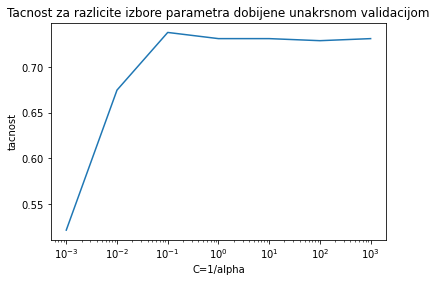

In [58]:
# crtamo grafika tacnosti na validacionom skupu za razlicite vrednosti parametra C=1/alpha
plt.plot(Cs, validation_scores)
plt.title('Tacnost za razlicite izbore parametra dobijene unakrsnom validacijom')
plt.xscale('log')
plt.xlabel('C=1/alpha')
plt.ylabel('tacnost')
plt.show()

In [59]:
print('Optimalna tacnost na skupu za validaciju je: %.3f' %optimal_score)

Optimalna tacnost na skupu za validaciju je: 0.738


In [60]:
print('Optimalo C je: %.1f' %optimal_C)

Optimalo C je: 0.1


In [61]:
# sada za optimal_C pravimo konacni model
# prvo skaliramo podatke
scaler_l1 = preprocessing.StandardScaler()
scaler_l1.fit(X_train_and_validation[:, 0:4])
X_train_and_validation[:, 0:4] = scaler_l1.transform(X_train_and_validation[:, 0:4])
X_test[:, 0:4] = scaler_l1.transform(X_test[:, 0:4])

In [62]:
logistic_regression_l1 = linear_model.LogisticRegression(penalty='l1', solver='saga', C=optimal_C, max_iter=2000)

In [63]:
logistic_regression_l1.fit(X_train_and_validation, y_train_and_validation)

LogisticRegression(C=0.1, max_iter=2000, penalty='l1', solver='saga')

In [64]:
pragovi

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [65]:
accuracy_scores_l1 = []
sensitivity_scores_l1 = []
specificity_scores_l1 = []

for prag in pragovi:
    # gledamo da li je verovatnoca pripadanja pozitivnoj klasi veca od praga
    # ako jeste, funkcija astype(int) vraca vrednost 1, a ako nije, vraca vrednost 0
    y_predicted = (logistic_regression_l1.predict_proba(X_test)[:,1] > prag).astype(int)
    
    # sada nam trebaju vrednosti TN, FP, FN, TP
    # njih nalazimo u matrici konfuzije (samo cemo je poravnati u vektor)
    TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_predicted).ravel()
    
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    accuracy_scores_l1.append(accuracy)
    sensitivity = TP/(TP+FN)
    sensitivity_scores_l1.append(sensitivity)
    specificity = TN/(TN+FP)
    specificity_scores_l1.append(specificity)

In [66]:
sensitivity_scores_l1 = np.array(sensitivity_scores_l1)
specificity_scores_l1 = np.array(specificity_scores_l1)

In [67]:
metrics.confusion_matrix(y_test, logistic_regression_l1.predict(X_test))

array([[512, 113],
       [122, 359]], dtype=int64)

In [68]:
l1_f1 = metrics.f1_score(y_test, logistic_regression_l1.predict(X_test))
print('f1 score za model logisticke regresije sa l1 regularizacijom: %.3f' %l1_f1) 

f1 score za model logisticke regresije sa l1 regularizacijom: 0.753


In [69]:
l1_auc = metrics.auc(1 - specificity_scores_l1, sensitivity_scores_l1)

In [70]:
print('AUC za model logisticke regresije sa l1 regularizacijom: %.3f' %l1_auc) 

AUC za model logisticke regresije sa l1 regularizacijom: 0.857


In [71]:
l1_accuracy = accuracy_scores_l1[5]
print('Tacnost za model logisticke regresije sa l1 regularizacijom: %.3f' %l1_accuracy)

Tacnost za model logisticke regresije sa l1 regularizacijom: 0.788


In [72]:
l1_sensitivity = sensitivity_scores_l1[5]
print('Senzitivnost za model logisticke regresije sa l1 regularizacijom: %.3f' %l1_sensitivity)

Senzitivnost za model logisticke regresije sa l1 regularizacijom: 0.746


In [73]:
l1_specificity = specificity_scores_l1[5]
print('Specificnost za model logisticke regresije sa l1 regularizacijom: %.3f' %l1_specificity)

Specificnost za model logisticke regresije sa l1 regularizacijom: 0.819


# Poredjenje rezultata logisticke regresije sa i bez regularizacije

In [74]:
print('Tacnost:')
print('Logisticka regresija: %.3f' %logistic_regression_accuracy)
print('Logisticka regresija sa l2 regularizacijom: %.3f' %l2_accuracy)
print('Logisticka regresija sa l1 regularizacijom: %.3f' %l1_accuracy)

Tacnost:
Logisticka regresija: 0.782
Logisticka regresija sa l2 regularizacijom: 0.788
Logisticka regresija sa l1 regularizacijom: 0.788


In [75]:
print('Senzitivnost:')
print('Logisticka regresija: %.3f' %logistic_regression_sensitivity)
print('Logisticka regresija sa l2 regularizacijom: %.3f' %l2_sensitivity)
print('Logisticka regresija sa l1 regularizacijom: %.3f' %l1_sensitivity)

Senzitivnost:
Logisticka regresija: 0.742
Logisticka regresija sa l2 regularizacijom: 0.744
Logisticka regresija sa l1 regularizacijom: 0.746


In [76]:
print('Specificnost:')
print('Logisticka regresija: %.3f' %logistic_regression_specificity)
print('Logisticka regresija sa l2 regularizacijom: %.3f' %l2_specificity)
print('Logisticka regresija sa l1 regularizacijom: %.3f' %l1_specificity)

Specificnost:
Logisticka regresija: 0.813
Logisticka regresija sa l2 regularizacijom: 0.822
Logisticka regresija sa l1 regularizacijom: 0.819


In [77]:
print('AUC:')
print('Logisticka regresija: %.3f' %logistic_regression_auc)
print('Logisticka regresija sa l2 regularizacijom: %.3f' %l2_auc)
print('Logisticka regresija sa l1 regularizacijom: %.3f' %l1_auc)

AUC:
Logisticka regresija: 0.857
Logisticka regresija sa l2 regularizacijom: 0.860
Logisticka regresija sa l1 regularizacijom: 0.857


In [78]:
print('f1:')
print('Logisticka regresija: %.3f' %logistic_regression_f1)
print('Logisticka regresija sa l2 regularizacijom: %.3f' %l2_f1)
print('Logisticka regresija sa l1 regularizacijom: %.3f' %l1_f1)

f1:
Logisticka regresija: 0.748
Logisticka regresija sa l2 regularizacijom: 0.754
Logisticka regresija sa l1 regularizacijom: 0.753


Najbolje je se pokazao model sa l2 regularizacijom.

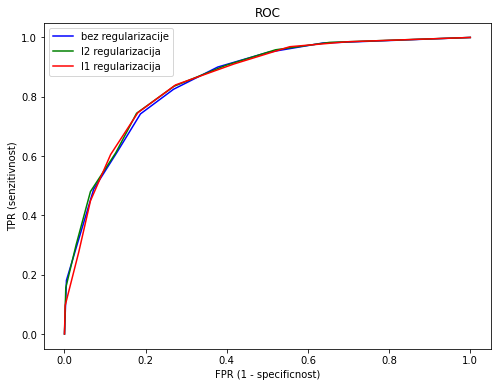

In [79]:
plt.figure(figsize=[8,6])
plt.plot(1 - specificity_scores, sensitivity_scores, color='blue', label='bez regularizacije')
plt.plot(1 - specificity_scores_l2, sensitivity_scores_l2, color='green', label='l2 regularizacija')
plt.plot(1 - specificity_scores_l1, sensitivity_scores_l1, color='red', label='l1 regularizacija')
plt.title('ROC')
plt.xlabel('FPR (1 - specificnost)')
plt.ylabel('TPR (senzitivnost)')
plt.legend(loc='best')
plt.show()

# Metoda k najblizih suseda 

In [80]:
X_train_and_validation, X_test, y_train_and_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

In [81]:
# imamo parametar k 

In [82]:
ks = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [83]:
# unakrsnom validacijom trazimo najbolje k
optimal_score = 0
optimal_k = 0
validation_scores = []

for k in ks:
    model = neighbors.KNeighborsClassifier(n_neighbors=k)
    scores = cross_validation(model, X_train_and_validation, y_train_and_validation)
    score = sum(scores)/len(scores)
    validation_scores.append(score)
    
    if score > optimal_score:
        optimal_score = score
        optimal_k = k

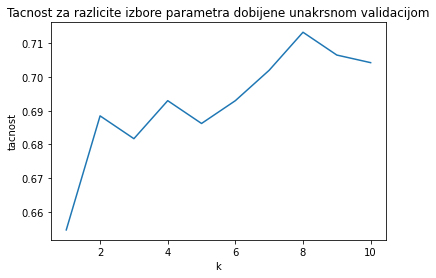

In [84]:
# crtamo grafika tacnosti na validacionom skupu za razlicite vrednosti parametra k
plt.plot(ks, validation_scores)
plt.title('Tacnost za razlicite izbore parametra dobijene unakrsnom validacijom')
plt.xlabel('k')
plt.ylabel('tacnost')
plt.show()

In [85]:
print('Optimalna tacnost na skupu za validaciju je: %.3f' %optimal_score)

Optimalna tacnost na skupu za validaciju je: 0.713


In [86]:
print('Optimalno k je:',optimal_k)

Optimalno k je: 8


In [87]:
# sada za optimal_k pravimo konacni model
# prvo skaliramo podatke
scaler_knn = preprocessing.StandardScaler()
scaler_knn.fit(X_train_and_validation[:, 0:4])
X_train_and_validation[:, 0:4] = scaler_knn.transform(X_train_and_validation[:, 0:4])
X_test[:, 0:4] = scaler_knn.transform(X_test[:, 0:4])

In [88]:
# model
knn = neighbors.KNeighborsClassifier(n_neighbors=optimal_k)

In [89]:
knn.fit(X_train_and_validation, y_train_and_validation)

KNeighborsClassifier(n_neighbors=8)

In [90]:
pragovi

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [91]:
accuracy_scores_knn = []
sensitivity_scores_knn = []
specificity_scores_knn = []

for prag in pragovi:
    # gledamo da li je verovatnoca pripadanja pozitivnoj klasi veca od praga
    # ako jeste, funkcija astype(int) vraca vrednost 1, a ako nije, vraca vrednost 0
    y_predicted = (knn.predict_proba(X_test)[:,1] > prag).astype(int)
    
    # sada nam trebaju vrednosti TN, FP, FN, TP
    # njih nalazimo u matrici konfuzije (samo cemo je poravnati u vektor)
    TN, FP, FN, TP = metrics.confusion_matrix(y_test, y_predicted).ravel()
    
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    accuracy_scores_knn.append(accuracy)
    sensitivity = TP/(TP+FN)
    sensitivity_scores_knn.append(sensitivity)
    specificity = TN/(TN+FP)
    specificity_scores_knn.append(specificity)

In [92]:
sensitivity_scores_knn = np.array(sensitivity_scores_knn)
specificity_scores_knn = np.array(specificity_scores_knn)

In [93]:
metrics.confusion_matrix(y_test, knn.predict(X_test))

array([[487, 138],
       [155, 326]], dtype=int64)

In [94]:
knn_f1 = metrics.f1_score(y_test, knn.predict(X_test))
print('f1 score za model k najblizih suseda: %.3f' %knn_f1) 

f1 score za model k najblizih suseda: 0.690


In [95]:
knn_auc = metrics.auc(1 - specificity_scores_knn, sensitivity_scores)
print('AUC za model k najblizih suseda: %.3f' %knn_auc)

AUC za model k najblizih suseda: 0.571


In [96]:
knn_accuracy = accuracy_scores_knn[5]
print('Tacnost za model k najblizih suseda: %.3f' %knn_accuracy)

Tacnost za model k najblizih suseda: 0.735


In [97]:
knn_sensitivity = sensitivity_scores_knn[5]
print('Senzitivnost za model k najblizih suseda: %.3f' %knn_sensitivity)

Senzitivnost za model k najblizih suseda: 0.678


In [98]:
knn_specificity = specificity_scores_knn[5]
print('Specificnost za model k najblizih suseda: %.3f' %knn_specificity)

Specificnost za model k najblizih suseda: 0.779


In [99]:
# ovaj model nam se nije bas najbolje pokazao

# Poredjenje rezultata 

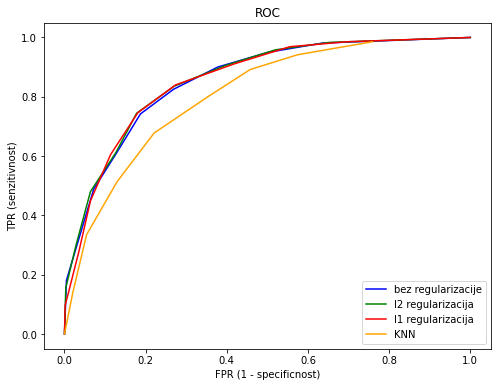

In [100]:
plt.figure(figsize=[8,6])
plt.plot(1 - specificity_scores, sensitivity_scores, color='blue', label='bez regularizacije')
plt.plot(1 - specificity_scores_l2, sensitivity_scores_l2, color='green', label='l2 regularizacija')
plt.plot(1 - specificity_scores_l1, sensitivity_scores_l1, color='red', label='l1 regularizacija')
plt.plot(1 - specificity_scores_knn, sensitivity_scores_knn, color='orange', label='KNN')
plt.title('ROC')
plt.xlabel('FPR (1 - specificnost)')
plt.ylabel('TPR (senzitivnost)')
plt.legend(loc='best')
plt.show()

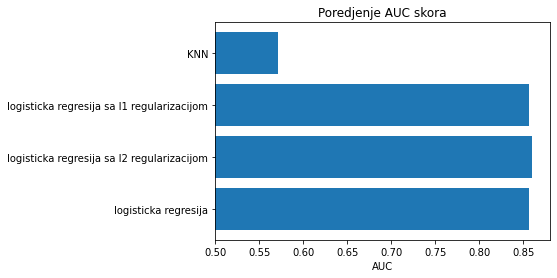

In [101]:
plt.barh([0, 1, 2, 3], [logistic_regression_auc, l2_auc, l1_auc, knn_auc])
plt.yticks([0, 1, 2, 3], ['logisticka regresija', 'logisticka regresija sa l2 regularizacijom', 'logisticka regresija sa l1 regularizacijom', 'KNN'])
plt.xlim([0.5, 0.88])
plt.xlabel('AUC')
plt.title('Poredjenje AUC skora')
plt.show()

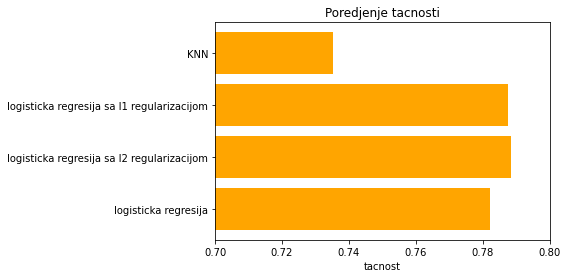

In [102]:
plt.barh([0, 1, 2, 3], [logistic_regression_accuracy, l2_accuracy, l1_accuracy, knn_accuracy], color='orange')
plt.yticks([0, 1, 2, 3], ['logisticka regresija', 'logisticka regresija sa l2 regularizacijom', 'logisticka regresija sa l1 regularizacijom', 'KNN'])
plt.xlim([0.7, 0.8])
plt.xlabel('tacnost')
plt.title('Poredjenje tacnosti')
plt.show()

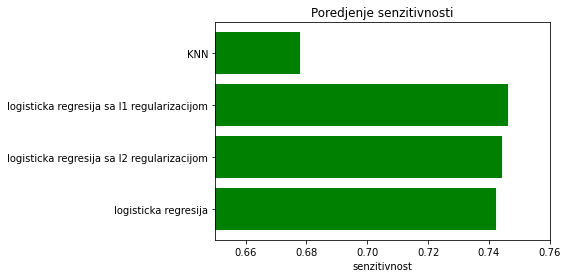

In [103]:
plt.barh([0, 1, 2, 3], [logistic_regression_sensitivity, l2_sensitivity, l1_sensitivity, knn_sensitivity], color='green')
plt.yticks([0, 1, 2, 3], ['logisticka regresija', 'logisticka regresija sa l2 regularizacijom', 'logisticka regresija sa l1 regularizacijom', 'KNN'])
plt.xlim([0.65, 0.76])
plt.xlabel('senzitivnost')
plt.title('Poredjenje senzitivnosti')
plt.show()

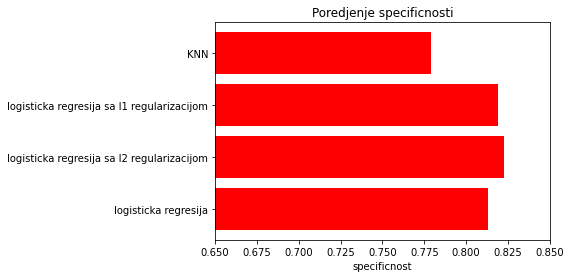

In [104]:
plt.barh([0, 1, 2, 3], [logistic_regression_specificity, l2_specificity, l1_specificity, knn_specificity], color='red')
plt.yticks([0, 1, 2, 3], ['logisticka regresija', 'logisticka regresija sa l2 regularizacijom', 'logisticka regresija sa l1 regularizacijom', 'KNN'])
plt.xlim([0.65, 0.85])
plt.xlabel('specificnost')
plt.title('Poredjenje specificnosti')
plt.show()

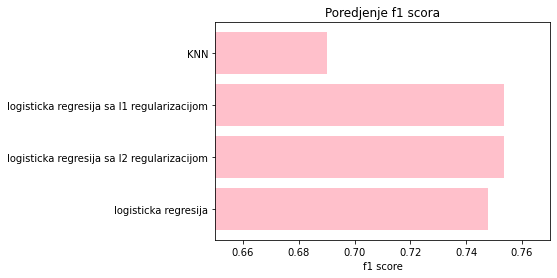

In [105]:
plt.barh([0, 1, 2, 3], [logistic_regression_f1, l2_f1, l1_f1, knn_f1], color='pink')
plt.yticks([0, 1, 2, 3], ['logisticka regresija', 'logisticka regresija sa l2 regularizacijom', 'logisticka regresija sa l1 regularizacijom', 'KNN'])
plt.xlim([0.65, 0.77])
plt.xlabel('f1 score')
plt.title('Poredjenje f1 scora')
plt.show()

Najbolje je se pokazao model logisticke regresije sa l2 regularizacijom sa parametrom alpha = 10. 

Ovaj model ima tacnost 0.788, AUC 0.86, f1 score 0.754, senzitivnost 0.744 i specificnost 0.822.

# Neuronska mreza 

In [106]:
from tensorflow import keras

In [107]:
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Dropout
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import Accuracy

In [108]:
# delimo skup podataka 
X_train_and_validation, X_test, y_train_and_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

In [109]:
# preprocesiranje
scaler_neural_network = preprocessing.StandardScaler()
scaler_neural_network.fit(X_train_and_validation[:, 0:4])
X_train_and_validation[:, 0:4] = scaler_neural_network.transform(X_train_and_validation[:, 0:4])
X_test[:, 0:4] = scaler_neural_network.transform(X_test[:, 0:4])

In [110]:
X_train_and_validation.shape

(4422, 259)

In [111]:
# dakle, ulazni sloj ce imati 259 neurona

In [112]:
# model
neural_network = Sequential([
    InputLayer(input_shape=(259,)),
    Dense(units=517, activation='relu'),
    Dropout(rate=0.5),
    Dense(units=259, activation='relu'),
    Dropout(rate=0.4),
    Dense(units=129, activation='relu'),
    Dropout(rate=0.3),
    Dense(units=64, activation='relu'),
    Dropout(rate=0.2),
    Dense(units=1, activation='sigmoid')
])

In [113]:
neural_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 517)               134420    
                                                                 
 dropout (Dropout)           (None, 517)               0         
                                                                 
 dense_1 (Dense)             (None, 259)               134162    
                                                                 
 dropout_1 (Dropout)         (None, 259)               0         
                                                                 
 dense_2 (Dense)             (None, 129)               33540     
                                                                 
 dropout_2 (Dropout)         (None, 129)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [114]:
neural_network.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [115]:
# treniranje mreze
history = neural_network.fit(X_train_and_validation, y_train_and_validation, epochs=30, batch_size=32, validation_split=0.1, verbose=0)

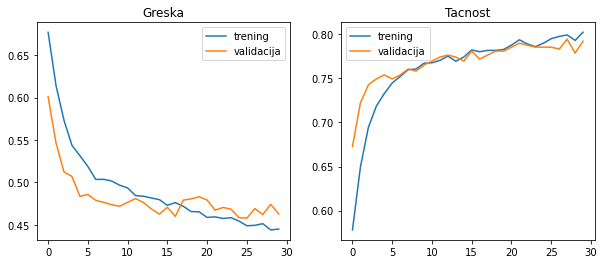

In [116]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Greska')
plt.plot(history.epoch, history.history['loss'], label='trening')
plt.plot(history.epoch, history.history['val_loss'], label='validacija')
plt.legend(loc='best')
plt.subplot(1, 2, 2)
plt.title('Tacnost')
plt.plot(history.epoch, history.history['accuracy'], label='trening')
plt.plot(history.epoch, history.history['val_accuracy'], label='validacija')
plt.legend(loc='best')
plt.show()

In [117]:
# evaluacija
scores = neural_network.evaluate(X_test, y_test)
scores

35/35 [==============================] - 0s 4ms/step - loss: 0.4568 - accuracy: 0.7866


[0.4568316340446472, 0.7866184711456299]

In [118]:
neural_network_accuracy = scores[1]
print('Tacnost je: %.3f' %neural_network_accuracy)

Tacnost je: 0.787


In [119]:
y_predicted = neural_network.predict(X_test)
y_predicted = (y_predicted > 0.5).astype(int)

35/35 [==============================] - 0s 3ms/step


In [120]:
neural_network_f1 = metrics.f1_score(y_test, y_predicted)
print('F1 score je: %.3f' %neural_network_f1)

F1 score je: 0.746


In [121]:
neural_network_auc = metrics.roc_auc_score(y_test, y_predicted)
print('AUC je: %.3f' %neural_network_auc)

AUC je: 0.779


In [122]:
print(metrics.confusion_matrix(y_test, y_predicted))

[[524 101]
 [135 346]]


Kada uporedimo sa logistickom regresijom sa l2 regularizacijom, vidimo da je ona ipak bolja.

In [123]:
print('Tacnost za logicticku regresiju sa l2 regularizacijom: %.3f' %l2_accuracy)
print('Tacnost za neuronsku mrezu: %.3f' %neural_network_accuracy)

Tacnost za logicticku regresiju sa l2 regularizacijom: 0.788
Tacnost za neuronsku mrezu: 0.787


In [124]:
print('F1 score za logicticku regresiju sa l2 regularizacijom: %.3f' %l2_f1)
print('F1 score za neuronsku mrezu: %.3f' %neural_network_f1)

F1 score za logicticku regresiju sa l2 regularizacijom: 0.754
F1 score za neuronsku mrezu: 0.746


In [125]:
print('AUC za logicticku regresiju sa l2 regularizacijom: %.3f' %l2_auc)
print('AUC za neuronsku mrezu: %.3f' %neural_network_auc)

AUC za logicticku regresiju sa l2 regularizacijom: 0.860
AUC za neuronsku mrezu: 0.779


Dakle, na kraju nam je ipak najbolji model - logisticka regresija sa l2 regularizacijom.

# Cuvanje najboljeg modela 

In [126]:
import pickle

In [127]:
with open ('required_dosage_of_warfarin_classification.model', 'wb') as pickle_file:
    pickle.dump(logistic_regression_l2, pickle_file)

In [128]:
with open ('required_dosage_of_warfarin_classification.scaler', 'wb') as pickle_file:
    pickle.dump(scaler_l2, pickle_file)